In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import geoplot
import pandas as pd
import numpy as np
import os
from shapely.geometry import Point
import re
from math import *
import csv
import xlrd
import copy
import json
import mapclassify

In [2]:
# load the districution data
covid = open('./data/covid_districution.json', 'r')
covid_districution = json.loads(covid.read())
covid.close()
bed = open('./data/bed_districution.json', 'r')
bed_districution = json.loads(bed.read())
bed.close()
pop = open('./data/pop_districution.json', 'r')
pop_districution = json.loads(pop.read())
pop.close()


In [3]:
# discrepancy
import numpy as np

def find_sign_change_array(a):
    asign = np.sign(a)
    sz = asign == 0
    if sz.any():
        asign[sz] = np.roll(asign, 1)[sz]
        sz = asign == 0
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    signchange[0] = 0
    return signchange

def get_regions(a):
    sgn = find_sign_change_array(a)
    regs= []
    i = 0
    for j,s in enumerate(sgn):
        if s==1:
            regs += [(i,j,np.sign(a[i]))]
            i = j
    if i<j:
        regs += [(i,j,np.sign(a[i]))]
    return regs

def compute_discrepancy(source0, target0, weights=None):
    weights = np.ones(len(source0)) if weights is None else weights
    source = weights * source0
    target = weights * target0
    dif = source - target
    reg = get_regions(dif)
    top = np.array([max([i,j]) for i,j in zip(source,target)])
    tot_disc = dif.sum()/float(target.sum())
    disc=[]
    for (i,j,s) in reg:
        d = dif[i:j].sum() / float(top[i:j].sum())
        disc += [(i,j,d)]
    return tot_disc, disc

# effort
from scipy.stats import wasserstein_distance

def compute_effort_emd(source, target, weights=None):
    return wasserstein_distance(source, target, u_weights=weights, v_weights=weights)

In [4]:
# calculate discrepancy and effort
discrepancy_bed_covid, discrepancy_pop_covid, discrepancy_bed_pop = {}, {}, {}
effort_bed_covid, effort_pop_covid, effort_bed_pop = {}, {}, {}
for s in covid_districution.keys():
    discr_bed_covid = compute_discrepancy(bed_districution[s], covid_districution[s])
    discr_bed_pop = compute_discrepancy(bed_districution[s], pop_districution[s])
    discr_pop_covid = compute_discrepancy(pop_districution[s], covid_districution[s])
    
    discrepancy_bed_covid[s] = discr_bed_covid
    discrepancy_bed_pop[s] = discr_bed_pop
    discrepancy_pop_covid[s] = discr_pop_covid
    
    eff_bed_covid = compute_effort_emd(bed_districution[s], covid_districution[s])
    eff_bed_pop = compute_effort_emd(bed_districution[s], pop_districution[s])
    eff_pop_covid = compute_effort_emd(pop_districution[s], covid_districution[s])
    
    effort_bed_covid[s] = eff_bed_covid
    effort_bed_pop[s] = eff_bed_pop
    effort_pop_covid[s] = eff_pop_covid

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sign
  """


# bed & covid

In [5]:
# descrepancy_bed_covid
df_discrepancy_bed_covid = pd.DataFrame.from_dict(discrepancy_bed_covid, orient="index", columns=["bed_covid_discrepancy","bed_covid_details"])
df_discrepancy_bed_covid = df_discrepancy_bed_covid.reset_index().rename(columns={"index":"STATE"})
df_discrepancy_bed_covid["bed_covid_discrepancy"] = df_discrepancy_bed_covid["bed_covid_discrepancy"].fillna(0)
# df_discrepancy_bed_covid

# effort_bed_covid
df_effort_bed_covid = pd.DataFrame.from_dict(effort_bed_covid, orient="index", columns=["bed_covid_effort"])
df_effort_bed_covid = df_effort_bed_covid.reset_index().rename(columns={"index":"STATE"})
df_effort_bed_covid["bed_covid_effort"] = df_effort_bed_covid["bed_covid_effort"].fillna(0)
# df_effort_bed_covid

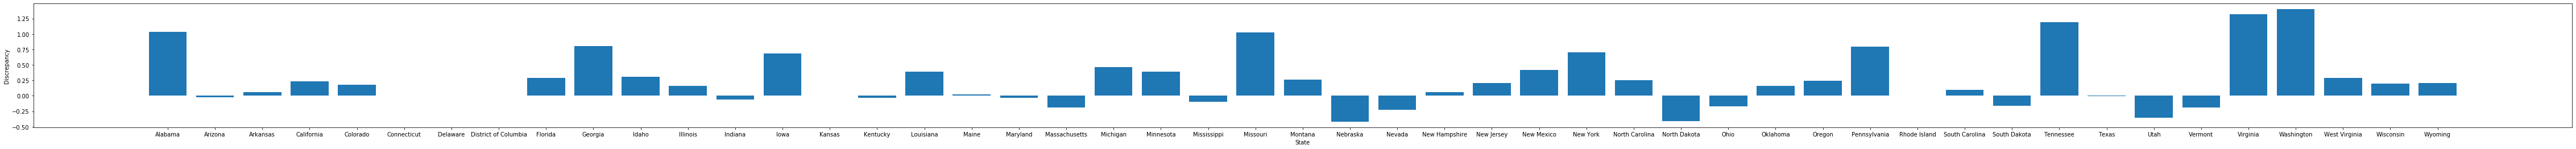

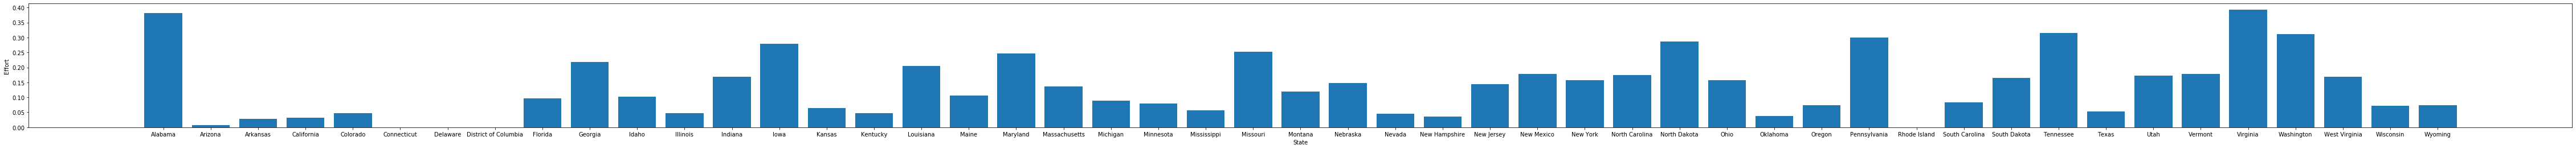

In [6]:
plt.rcParams['figure.figsize'] = (80, 4.0)
plt.figure()
plt.bar(df_discrepancy_bed_covid["STATE"],df_discrepancy_bed_covid["bed_covid_discrepancy"])
plt.xlabel("State")
plt.ylabel("Discrepancy")
plt.show()

plt.figure()
plt.bar(df_effort_bed_covid["STATE"],df_effort_bed_covid["bed_covid_effort"])
plt.xlabel("State")
plt.ylabel("Effort")
plt.show()

In [7]:
# count for discrepancy (<0, =0, >0)
df_discrepancy_bed_covid['level'] = df_discrepancy_bed_covid.apply(lambda x: np.sign(x.bed_covid_discrepancy), axis = 1)
# df_discrepancy_bed_covid
count_dis_bed_covid = df_discrepancy_bed_covid.groupby("level")["STATE"].size()
count_dis_bed_covid

level
-1.0    14
 0.0     4
 1.0    31
Name: STATE, dtype: int64

# population & covid

In [8]:
# discrepancy_pop_covid
df_discrepancy_pop_covid = pd.DataFrame.from_dict(discrepancy_pop_covid, orient="index", columns=["pop_covid_discrepancy","pop_covid_details"])
df_discrepancy_pop_covid = df_discrepancy_pop_covid.reset_index().rename(columns={"index":"STATE"})
df_discrepancy_pop_covid["pop_covid_discrepancy"] = df_discrepancy_pop_covid["pop_covid_discrepancy"].fillna(0)
# df_discrepancy_pop_covid

# effort_pop_covid
df_effort_pop_covid = pd.DataFrame.from_dict(effort_pop_covid, orient="index", columns=["pop_covid_effort"])
df_effort_pop_covid = df_effort_pop_covid.reset_index().rename(columns={"index":"STATE"})
df_effort_pop_covid["pop_covid_effort"] = df_effort_pop_covid["pop_covid_effort"].fillna(0)
# df_effort_pop_covid

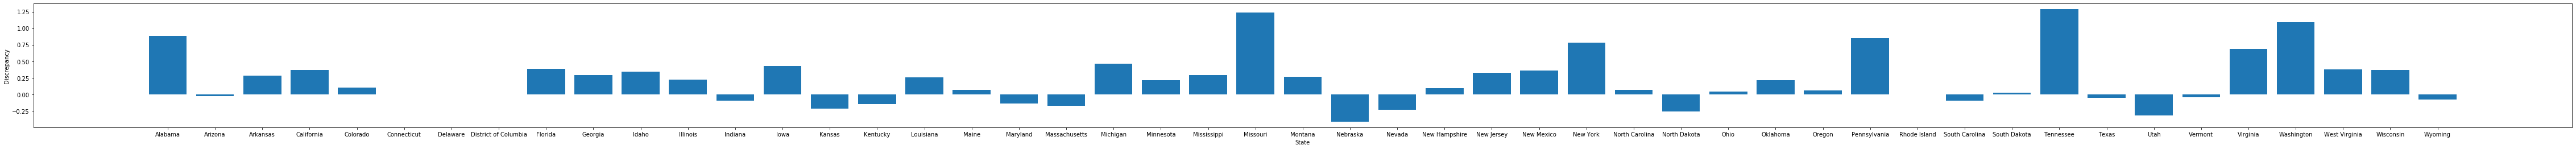

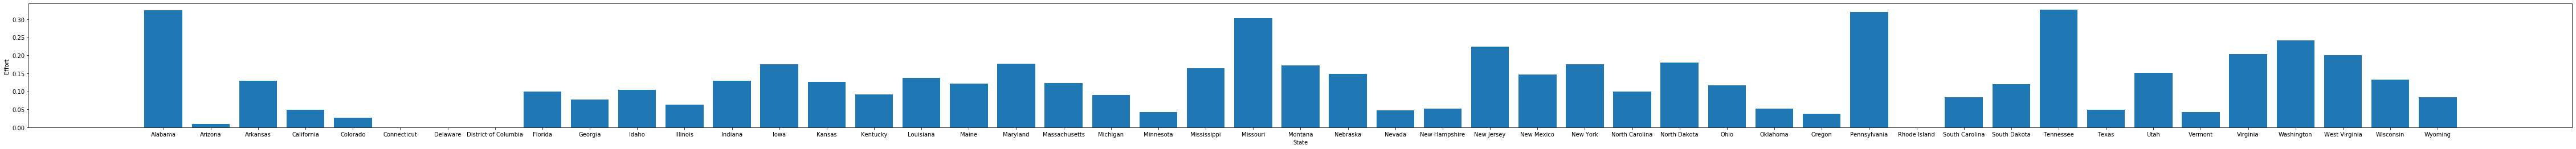

In [9]:
plt.rcParams['figure.figsize'] = (80, 4.0)
plt.figure()
plt.bar(df_discrepancy_pop_covid["STATE"],df_discrepancy_pop_covid["pop_covid_discrepancy"])
plt.xlabel("State")
plt.ylabel("Discrepancy")
plt.show()

plt.figure()
plt.bar(df_effort_pop_covid["STATE"],df_effort_pop_covid["pop_covid_effort"])
plt.xlabel("State")
plt.ylabel("Effort")
plt.show()

In [10]:
# count for discrepancy (<0, =0, >0)
df_discrepancy_pop_covid['level'] = df_discrepancy_pop_covid.apply(lambda x: np.sign(x.pop_covid_discrepancy), axis = 1)
# df_discrepancy_bed_covid
count_dis_pop_covid = df_discrepancy_pop_covid.groupby("level")["STATE"].size()
count_dis_pop_covid

level
-1.0    14
 0.0     4
 1.0    31
Name: STATE, dtype: int64

# bed & population

In [11]:
# discrepancy_bed_pop
df_discrepancy_bed_pop = pd.DataFrame.from_dict(discrepancy_bed_pop, orient="index", columns=["bed_pop_discrepancy","bed_pop_details"])
df_discrepancy_bed_pop = df_discrepancy_bed_pop.reset_index().rename(columns={"index":"STATE"})
df_discrepancy_bed_pop["bed_pop_discrepancy"] = df_discrepancy_bed_pop["bed_pop_discrepancy"].fillna(0)
# df_discrepancy_bed_pop

# effort_bed_pop
df_effort_bed_pop = pd.DataFrame.from_dict(effort_bed_pop, orient="index", columns=["bed_pop_effort"])
df_effort_bed_pop = df_effort_bed_pop.reset_index().rename(columns={"index":"STATE"})
df_effort_bed_pop["bed_pop_effort"] = df_effort_bed_pop["bed_pop_effort"].fillna(0)
# df_effort_bed_pop

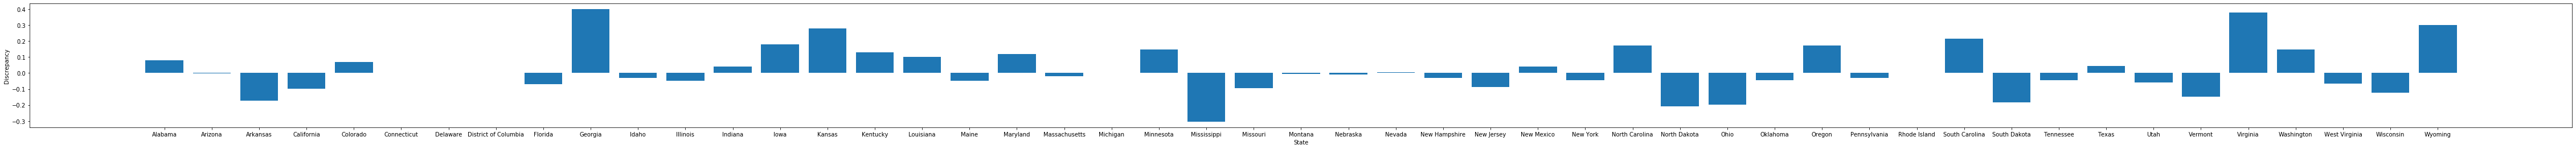

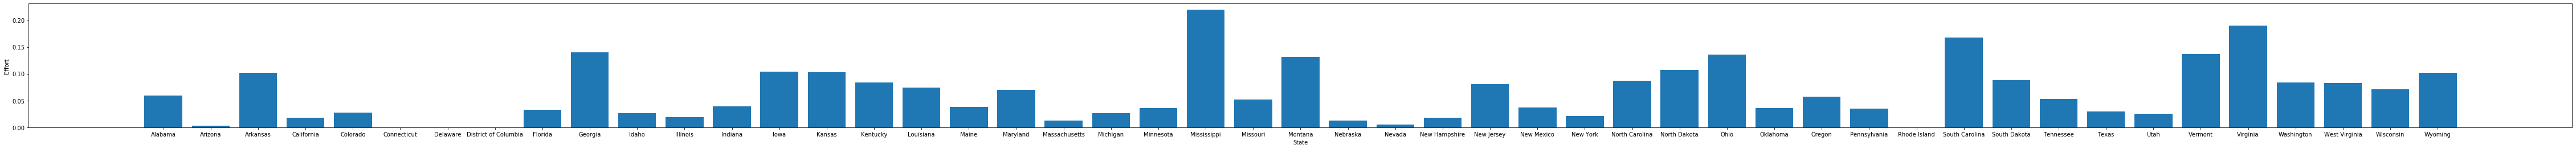

In [12]:
plt.rcParams['figure.figsize'] = (80, 4.0)
plt.figure()
plt.bar(df_discrepancy_bed_pop["STATE"],df_discrepancy_bed_pop["bed_pop_discrepancy"])
plt.xlabel("State")
plt.ylabel("Discrepancy")
plt.show()

plt.figure()
plt.bar(df_effort_bed_pop["STATE"],df_effort_bed_pop["bed_pop_effort"])
plt.xlabel("State")
plt.ylabel("Effort")
plt.show()

In [13]:
# count for discrepancy (<0, =0, >0)
df_discrepancy_bed_pop['level'] = df_discrepancy_bed_pop.apply(lambda x: np.sign(x.bed_pop_discrepancy), axis = 1)
# df_discrepancy_bed_covid
count_dis_bed_pop = df_discrepancy_bed_pop.groupby("level")["STATE"].size()
count_dis_bed_pop

level
-1.0    25
 0.0     4
 1.0    20
Name: STATE, dtype: int64

# merge all results

In [14]:
df_final = pd.DataFrame(columns=["STATE"])
dfs=[df_discrepancy_bed_covid, df_discrepancy_pop_covid, df_discrepancy_bed_pop, df_effort_bed_covid, df_effort_pop_covid, df_effort_bed_pop]
for df in dfs:
    df_final = df_final.merge(df, on=['STATE'], how='outer')
df_final = df_final.drop(["bed_covid_details","pop_covid_details","bed_pop_details","level_x","level_y","level"],axis=1)
# drop DC
df_final = df_final.drop([7])
df_final = df_final.reset_index(drop=True)
df_final

,STATE,bed_covid_discrepancy,pop_covid_discrepancy,bed_pop_discrepancy,bed_covid_effort,pop_covid_effort,bed_pop_effort
0,Alabama,1.034654,0.881310,0.081509,0.381467,0.324931,0.059195
1,Arizona,-0.025015,-0.022918,-0.002146,0.007338,0.009136,0.003310
2,Arkansas,0.059166,0.280589,-0.172908,0.027170,0.128852,0.101682
3,California,0.238742,0.370906,-0.096406,0.031165,0.048417,0.017481
4,Colorado,0.182044,0.104893,0.069827,0.047063,0.027118,0.027743
5,Connecticut,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Delaware,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Florida,0.286983,0.385778,-0.071292,0.095888,0.099745,0.033064
8,Georgia,0.801181,0.286915,0.399611,0.217396,0.077853,0.139543
9,Idaho,0.306913,0.345533,-0.028703,0.101741,0.103568,0.026165


In [15]:
# max->min
import copy
ranks = copy.copy(df_final)
ranks[list(df_final.columns[1:])] = df_final[list(df_final.columns[1:])].rank(method="min", ascending=False)
ranks

,STATE,bed_covid_discrepancy,pop_covid_discrepancy,bed_pop_discrepancy,bed_covid_effort,pop_covid_effort,bed_pop_effort
0,Alabama,4.0,4.0,14.0,2.0,2.0,22.0
1,Arizona,36.0,35.0,24.0,45.0,45.0,45.0
2,Arkansas,29.0,19.0,44.0,44.0,21.0,12.0
3,California,20.0,12.0,41.0,43.0,38.0,41.0
4,Colorado,24.0,25.0,15.0,38.0,44.0,34.0
5,Connecticut,32.0,32.0,21.0,46.0,46.0,46.0
6,Delaware,32.0,32.0,21.0,46.0,46.0,46.0
7,Florida,15.0,10.0,38.0,27.0,28.0,32.0
8,Georgia,6.0,18.0,1.0,10.0,34.0,4.0
9,Idaho,14.0,15.0,28.0,26.0,27.0,36.0


In [16]:
outputpath = "./data/discr_eff/"
if not os.path.exists(outputpath):
    os.makedirs(outputpath)
df_final.to_csv(os.path.join(outputpath, "discr_eff_val.csv"))
ranks.to_csv(os.path.join(outputpath, "discr_eff_rank.csv"))